In [42]:
import pandas as pd
import numpy as np
import plotly.express as px
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import f
import seaborn as sns
from sklearn.linear_model import LinearRegression


%matplotlib inline

sns.set(style="darkgrid")
 
data = sm.datasets.macrodata.load_pandas().data

In [2]:
import warnings
warnings.filterwarnings("ignore") 

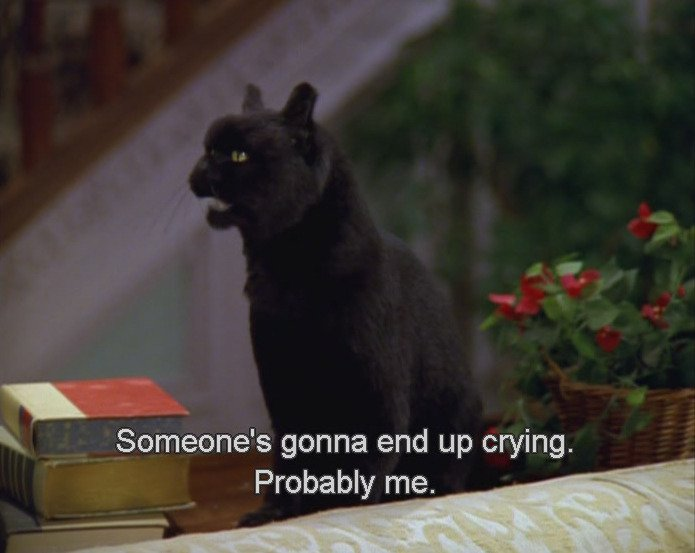

# Постановка задачи

Вам представлены квартальные макроэкономические данные США. В датасете представлен ВВП, его компоненты (совокупный доход, потребление и инвестиции), а также прочие показатели. Задача - спрогнозировать ВВП Америки на 8 кварталов вперёд. Метрика - MAPE. Все гипотезы тестируются на уровне значимости 5%.

## Обработка и визуализация. (0.5 балла)

Приведите в порядок переменную, отвечающую за время и преобразуйте её в формат pandas datetime с квартальной периодичностью. Визуализируйте ряд ВВП, его автокорреляции и частные автокорреляции. Какие характерные паттерны вы наблюдаете?

Опытным путем я узнала, что первый квартал 2007 года имеет индекс 192

Значит обрежем все после

In [3]:
data = data.loc[:191, :]
data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2005.0,4.0,12748.699,8888.5,2232.193,875.557,9358.7,199.400,1380.6,4.00,4.9,297.435,0.40,3.60
188,2006.0,1.0,12915.938,8986.6,2264.721,900.511,9533.8,200.700,1380.5,4.51,4.7,298.061,2.60,1.91
189,2006.0,2.0,12962.462,9035.0,2261.247,892.839,9617.3,202.700,1369.2,4.82,4.7,298.766,3.97,0.85
190,2006.0,3.0,12965.916,9090.7,2229.636,892.002,9662.5,201.900,1369.4,4.90,4.7,299.593,-1.58,6.48


In [4]:
data['year'] = pd.date_range('1959-01-01', '2006-10-01', freq ='QS')
data = data.drop(columns='quarter')

In [5]:
data

,year,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959-01-01,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959-04-01,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959-07-01,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959-10-01,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960-01-01,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,2005-10-01,12748.699,8888.5,2232.193,875.557,9358.7,199.400,1380.6,4.00,4.9,297.435,0.40,3.60
188,2006-01-01,12915.938,8986.6,2264.721,900.511,9533.8,200.700,1380.5,4.51,4.7,298.061,2.60,1.91
189,2006-04-01,12962.462,9035.0,2261.247,892.839,9617.3,202.700,1369.2,4.82,4.7,298.766,3.97,0.85
190,2006-07-01,12965.916,9090.7,2229.636,892.002,9662.5,201.900,1369.4,4.90,4.7,299.593,-1.58,6.48


In [6]:
fig = px.line(x=data.year, y=data.realgdp)
fig.update_layout(title='Ряд ВВП США',
                   xaxis_title='Время',
                   yaxis_title='Значение ВВП')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

Либо я сделала что-то не так, либо единственный паттерн, который тут ну прям совсем очевиден - это растущий тренд на протяжении всего промежутка измерений

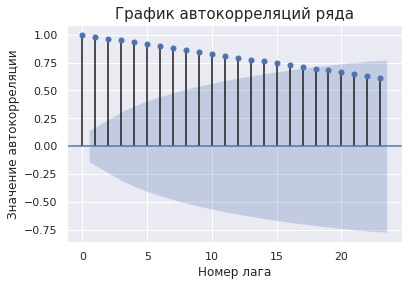

In [7]:
plot_acf(data.realgdp)
plt.title('График автокорреляций ряда', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение автокорреляции', size=12)
plt.show()

Заметим, что номер полседнего значимого лаг - 17 (тут не совсем ясно 16 или 17, но лучше возьмем больший). Это нам понадобится дальше. Также заметим, что значения автокорреляции постеменно убывают

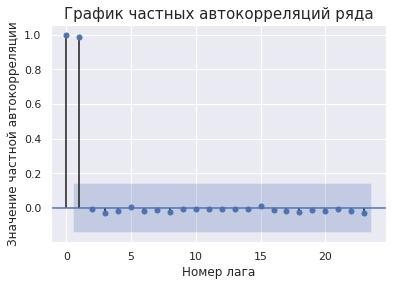

In [8]:
plot_pacf(data.realgdp)
plt.title('График частных автокорреляций ряда', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение частной автокорреляции', size=12)
plt.show()

Тут же все ясно, номер последнего значимого лага - 1

И также можем видеть, что после первого лага значения частичной автокорреляции резко падают и лаги становятся незначимыми. В целом оба паттерна - как в ACF, так и в PACF свойственны для ряда с детерменированным трендом. 

# Прогноз на основе эндогенной информации

## Определение порядка интеграции (1 балл)

Определите порядок интеграции ряда ВВП с помощью формальных тестов. В случае противоречий ADF и KPSS-теста, полагайтесь на KPSS-тест. За неправильную спецификацию функциональной формы вспомогательной регрессии для тестов оценка может быть снижена.




In [9]:
test = adfuller(data.realgdp, regression='ct')
print('adf:', test[0]) 
print('p-value:', test[1])
print('Critical values:', test[4])
if (test[0] > test[4]['5%']): 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Нет единичных корней, ряд стационарен')

adf: -0.4714309446339166
p-value: 0.9845129060713169
Critical values: {'1%': -4.007485705462188, '5%': -3.4339793108836276, '10%': -3.140843617555455}
Есть единичные корни, ряд не стационарен


In [10]:
test_2 = kpss(data.realgdp, regression='ct')
print('KPSS:', test_2[0]) 
print('p-value:', test_2[1])
print('Critical values:', test_2[3])
if (test_2[0] > test_2[3]['5%']): 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Нет единичных корней, ряд стационарен')

KPSS: 0.3141934513208436
p-value: 0.01
Critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Есть единичные корни, ряд не стационарен


Продифференцируем ряд первый раз

In [11]:
data_diff_1 = data.realgdp.diff(periods=1).dropna()

In [12]:
test = adfuller(data_diff_1,regression='ct')
print('adf:', test[0]) 
print('p-value:', test[1])
print('Critical values:', test[4])
if (test[0] > test[4]['5%']): 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Нет единичных корней, ряд стационарен')

adf: -6.937852646079291
p-value: 1.9522982484690265e-08
Critical values: {'1%': -4.007485705462188, '5%': -3.4339793108836276, '10%': -3.140843617555455}
Нет единичных корней, ряд стационарен


In [13]:
test_2 = kpss(data_diff_1, regression='ct')
print('KPSS:', test_2[0]) 
print('p-value:', test_2[1])
print('Critical values:', test_2[3])
if (test_2[0] > test_2[3]['5%']): 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Нет единичных корней, ряд стационарен')

KPSS: 0.0650205402903624
p-value: 0.1
Critical values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Нет единичных корней, ряд стационарен


Как мы видим, уже после первого дифференцирования оба критерия показывают, что ряд стал стационарным. Значит порядок интеграции ряда ВВП = 1

Посмотрим, как выглядит ряд после дифференцирования.

In [14]:
fig = px.line(x=data.year[:-1], y=data_diff_1)
fig.update_layout(title='Ряд ВВП США после дифференцирования',
                   xaxis_title='Время',
                   yaxis_title='Значение ВВП')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

Да, и правда похож на стационарный!

## ARIMA-модель (2 балла)

Для ряда ВВП подберите оптимальную ARIMA-модель согласно алгоритму с семинара. Для моделей-кандидатов определите максимальные порядки p и q исходя из коррелограмм, и отберите оптимальную модель из всех возможных комбинаций этих параметров. Можно не отбирать модели по AIC, а смотреть только на вневыборочное качество прогноза. Однако советую из любопытства всё же проверить, совпадут ли результаты отбора по информационным критериям и по вневыборочной точности.

Для отбора по качеству прогноза используйте любой из двух алгоритмов кросс-валидации и стратегию рекурсивного прогнозирования (она реализована по дефолту в statsmodels). Нужный класс уже импортирован в шапке.

Ну, в нашем случае d = 1, значит надо определить p и q. Как мы знаем, максимальные p и q можно определить по кореллограммам. q - номер последнего значимого лага в ACF (то есть у нас - 17), p - номер последнего значимого лага в PACF (то есть у нас - 1).


Что ж, теперь переберем кучу моделей ARIMA...

In [15]:
from sklearn.model_selection import TimeSeriesSplit

In [16]:
def mean_absolute_percentage_error(y_true, y_pred):  #mape из skrearn.metrics не импортится, ну что ж, я человек не гордый
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
best_params = []
best_mape = 100
for p in range(0, 18):
    for q in range(0, 2):
        mape_res = []
        tscv = TimeSeriesSplit(n_splits=5)
        for train_index, test_index in tscv.split(data.realgdp):
            train = data.loc[train_index, 'realgdp']
            test = data.loc[test_index, 'realgdp']
            model = ARIMA(train, order=(p,1,q))
            #иногда оно падает с "On entry to DLASCL parameter number 4 had an illegal value", так что будет так...
            try:
                pred = model.fit().forecast(steps=test.size)[0]
                mape_res.append(mean_absolute_percentage_error(test, pred))
            except:
                pred = np.inf

        mape_cur = np.array(mape_res).mean()
        if mape_cur < best_mape:
            best_mape = mape_cur
            best_params = [p, 1, q]
        print('При (p, d, q) = ', '(', p,', 1, ', q, '), MAPE = ', mape_cur, '%', sep='')

print()
print('Лучшие парметры (p, d, q) = ',  '(', *best_params, '), MAPE = ', best_mape, "%", sep='')

При (p, d, q) = (0, 1, 0), MAPE = 4.75941888466911%
При (p, d, q) = (0, 1, 1), MAPE = 4.764561222274027%
При (p, d, q) = (1, 1, 0), MAPE = 4.746928175676533%
При (p, d, q) = (1, 1, 1), MAPE = 4.986029075021312%
При (p, d, q) = (2, 1, 0), MAPE = 4.892353789624931%
При (p, d, q) = (2, 1, 1), MAPE = 4.950931496383291%
При (p, d, q) = (3, 1, 0), MAPE = 4.9249814785410795%
При (p, d, q) = (3, 1, 1), MAPE = 5.0871317644198015%
При (p, d, q) = (4, 1, 0), MAPE = 5.018208780385819%
При (p, d, q) = (4, 1, 1), MAPE = 5.087879303712538%
При (p, d, q) = (5, 1, 0), MAPE = 4.564742400783421%
При (p, d, q) = (5, 1, 1), MAPE = 3.936213679866129%
При (p, d, q) = (6, 1, 0), MAPE = 4.382143307758069%
При (p, d, q) = (6, 1, 1), MAPE = 3.8298629724304427%
При (p, d, q) = (7, 1, 0), MAPE = 4.216846496336491%
При (p, d, q) = (7, 1, 1), MAPE = 3.9915140434215592%
При (p, d, q) = (8, 1, 0), MAPE = 4.626469258298466%
При (p, d, q) = (8, 1, 1), MAPE = 4.52822972519334%
При (p, d, q) = (9, 1, 0), MAPE = 4.20337898

(О боже, как уродски вывелось (6, 1, 1)... Ну ладно, пересчитываеть я это не буду...)

Чем меньше значение MAPE - тем лучше, так что лучшей моделью оказалась ARIMA(6,1,1). Поздравляем победителя!!!! Вообще, как оказалось, тут все зависит от количества блоков кросс-валидации и прочего. Но вот на 5 блоках вышло вот такое. На большем количестве я бы умерла считать, оно итак вечность считалось...

## Тест причинности Гранжера (0.5 балла)

Постройте модель с распределёнными лагами для прогноза на один шаг вперёд. Для этого выберите одну из переменных, которую будете использовать в качестве регрессора. Кратко поясните свой выбор. Проверьте своё предположение, проведя тест причинности Гранжера. Тест импортирован в шапке. Количество лагов вспомогательной модели установите равным 8.

Обратите внимание, что для верного вывода необходимо провести тест в обе стороны, о чём было рассказано на семинаре. Внимательно прочитайте порядок подаваемых на вход переменных в документации теста. Не спорю, что документация statsmodels это нечто кошмарное, но на безрыбье и statsmodels нормальный пакет.



Выберем признак "realcons". Кажется, что он должен влиять на ВВП по очевидным причинам. "realcons" - это реальные расходы на личное потребление, а как мы знаем из экономики (спасибо, Таровик), они являются одной из составляющих ВВП.

Хотим, что бы регрессор realcons влиял на значение таргета, то есть на realgdp, а значение таргета не влияло на регрессор.

Для начала рассмотрим влияние регрессора на таргет, то есть будем проверять гипотезу:

$H_0:$ временной ряд из второй колонки не помогает в прогнозировании первой колонки 

In [18]:
new_data = data[['realgdp', 'realcons']]	

In [19]:
gr_t = grangercausalitytests(new_data, maxlag=8)
print()
print((np.array([gr_t[l][0]['ssr_ftest'] for l in range(1, 9)])[:, 1] >= 0.025) & (np.array([gr_t[l][0]['ssr_ftest'] for l in range(1, 9)])[:, 1]  <= 0.975))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9570  , p=0.0872  , df_denom=188, df_num=1
ssr based chi2 test:   chi2=3.0042  , p=0.0831  , df=1
likelihood ratio test: chi2=2.9808  , p=0.0843  , df=1
parameter F test:         F=2.9570  , p=0.0872  , df_denom=188, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=15.5602 , p=0.0000  , df_denom=185, df_num=2
ssr based chi2 test:   chi2=31.9615 , p=0.0000  , df=2
likelihood ratio test: chi2=29.5412 , p=0.0000  , df=2
parameter F test:         F=15.5602 , p=0.0000  , df_denom=185, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=12.1669 , p=0.0000  , df_denom=182, df_num=3
ssr based chi2 test:   chi2=37.9045 , p=0.0000  , df=3
likelihood ratio test: chi2=34.5459 , p=0.0000  , df=3
parameter F test:         F=12.1669 , p=0.0000  , df_denom=182, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=9.5293  , p=0.0000  

Гипотеза отвергается (ни у одного признака не было все False, я проверила, так что это лучшее). Значит мы можем брать признак realcons в качестве регрессора

Теперь поменяем столбцы местами и проверим наоборот влияние таргета на регрессор

In [20]:
new_data_2 = data[['realcons', 'realgdp']]

In [21]:
gr_t = grangercausalitytests(new_data_2, maxlag=8)
print()
print((np.array([gr_t[l][0]['ssr_ftest'] for l in range(1, 9)])[:, 1] >= 0.025) & (np.array([gr_t[l][0]['ssr_ftest'] for l in range(1, 9)])[:, 1]  <= 0.975))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0980  , p=0.7546  , df_denom=188, df_num=1
ssr based chi2 test:   chi2=0.0996  , p=0.7523  , df=1
likelihood ratio test: chi2=0.0996  , p=0.7524  , df=1
parameter F test:         F=0.0980  , p=0.7546  , df_denom=188, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8449  , p=0.4313  , df_denom=185, df_num=2
ssr based chi2 test:   chi2=1.7355  , p=0.4199  , df=2
likelihood ratio test: chi2=1.7276  , p=0.4216  , df=2
parameter F test:         F=0.8449  , p=0.4313  , df_denom=185, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5048  , p=0.6794  , df_denom=182, df_num=3
ssr based chi2 test:   chi2=1.5728  , p=0.6656  , df=3
likelihood ratio test: chi2=1.5663  , p=0.6671  , df=3
parameter F test:         F=0.5048  , p=0.6794  , df_denom=182, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2175  , p=0.3050  

Как мы можем видеть, гипотиза о том, что таргет не влияет на регрессор не отвергается, что нам и нужно. 

## Модель с распределёнными лагами (0.5 балла)

Для начала, оцените модель с распределёнными лагами для прогноза на один шаг. Для построения модели используйте последние 8 кварталов. Обратите внимание, что регрессировать нужно как минимум на первый лаг регрессора, а не на нулевой. В противном случае банально не получится построить прогноз. Для оценки модели используйте стандартную линейную регрессию. Можно использовать как реализацию из statsmodels, так и из любого другого адекватного пакета (например, sklearn).

Спецификация модели с распределёнными лагами:

$y_t = \beta_0 + \beta_1 x_{t-1} + ... + \beta_8 x_{t-8} + \epsilon_t$


Для начала создадим новый датафрейм для лагов (при работе с ним, очевидно, будем использовать тольок строки, в которых нет нанов, то есть начиная с 9)

In [23]:
x = data['realcons']
y = data['realgdp']
X = pd.DataFrame()
X['8'] = np.ones(192)
for i in range(0, 8):
    X.loc[:, i] = x[:-i - 1]
    X.loc[:, i] = X.loc[:, i].shift(i + 1)

In [24]:
X

,8,0,1,2,3,4,5,6,7
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1707.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1733.7,1707.4,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1751.8,1733.7,1707.4,NaN,NaN,NaN,NaN,NaN
4,1.0,1753.7,1751.8,1733.7,1707.4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
187,1.0,8865.6,8802.9,8719.0,8654.2,8555.8,8483.2,8437.6,8358.0
188,1.0,8888.5,8865.6,8802.9,8719.0,8654.2,8555.8,8483.2,8437.6
189,1.0,8986.6,8888.5,8865.6,8802.9,8719.0,8654.2,8555.8,8483.2
190,1.0,9035.0,8986.6,8888.5,8865.6,8802.9,8719.0,8654.2,8555.8


Обучаем линейную регрессию на полученных данных и поулчаем оценки коэффициентов

(также получим оценку на y, она пригодится нам в следующем пункте)

In [25]:
lr = LinearRegression(fit_intercept=False)
lr.fit(X.loc[8:, :], y[8:])

betas = []
for i in range(9):
    betas.append(lr.coef_[i])
    print('beta', i, '= %.4f' % lr.coef_[i])

beta 0 = 501.2053
beta 1 = 1.7066
beta 2 = 0.2655
beta 3 = -0.1833
beta 4 = -0.1295
beta 5 = -0.1539
beta 6 = 0.0405
beta 7 = -0.1487
beta 8 = -0.0033


In [26]:
hat_y_ur = X.loc[8:, :] @ betas

## Модель полиномиальных лагов (2 балла)

Постройте модель с полиномиальными лагами на основе предыдущей модели. Спецификация подробно описана в учебнике Магнуса, Катышева и Пересецкого на страницах 266-267 главы 11, учебник есть в чате. Попытайтесь подобрать модель с минимальной степенью полинома, для которой модель с ограничениями будет адекватной согласно F-тесту, либо покажите, что для любая степень полинома меньше 8 не удовлетворяет F-тесту. Тестовая статистика описана на тех же страницах.

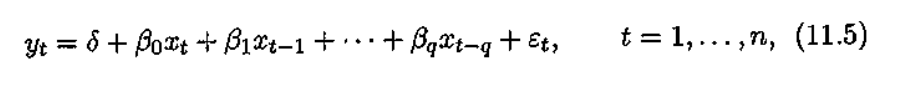
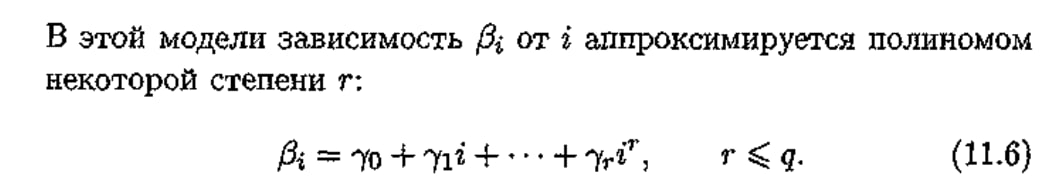

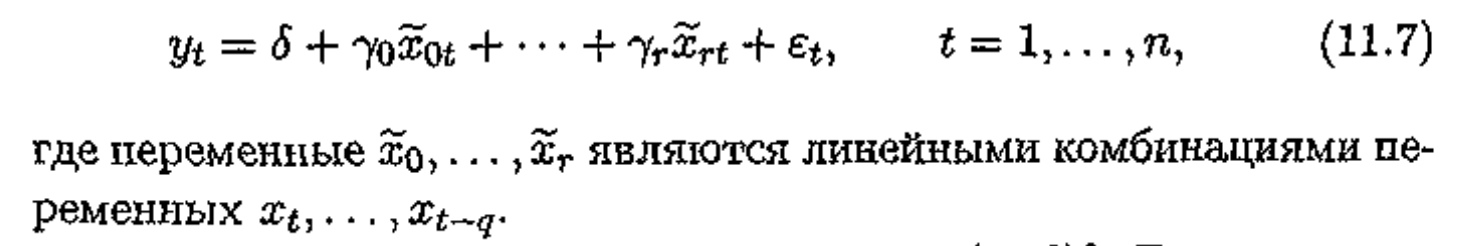

In [27]:
delta = betas[0]
betas = betas[1:]  #тут свободный член не понадобится

Теперь напишем функцию, которая по вектору бет находит гаммы по формуле 11.6 и затем строит прогноз на новые бетты, которые позже будут использоваться при подстановке формулы 11.6 в формулу 11.5

In [28]:
def find_betas(k, lr, betas):
    find_g = pd.DataFrame()
    for i in range(1, 9):
        find_g[i] = [i**j for j in range(0, k+1)]
    find_g = find_g.T

    gamas = lr.fit(find_g, betas).coef_
    res = lr.predict(find_g)
    return res

Проверим, что оно вообще работает

In [29]:
g = find_betas(7, LinearRegression(), betas)
g

array([ 1.70658988,  0.26546594, -0.18330088, -0.12951959, -0.1538744 ,
        0.04047816, -0.14868661, -0.00330023])

Ну, вроде работает

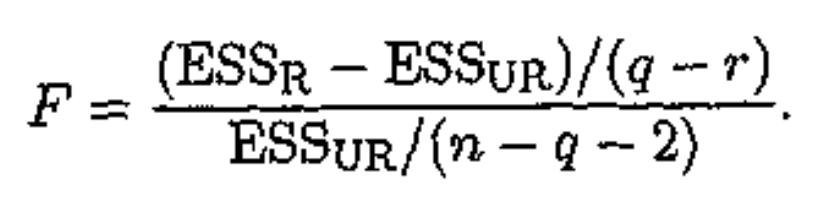

А теперь собственно расмотрим модели всех возможных порядков от 1 до 7, найдем для них предсказания y и посчитаем значение F-статистики

In [30]:
res = []
f_crit = []
for r in range(1, 8):
    betas_cur =  find_betas(r, LinearRegression(fit_intercept=False), betas)
    params = list([delta]) + list(betas_cur)
    hat_y_r = X.loc[8:, :] @ params
    ess_r = np.sum((hat_y_r - y[8:].mean())**2)
    ess_ur = np.sum((hat_y_ur - y[8:].mean())**2)
    num = (ess_r - ess_ur) / (8 - r)
    denom = (ess_ur) / (X.shape[0] - 8 - 2)
    cur_f = num / denom
    cur_crit = f.ppf(0.95, 8 - r, X.shape[0] - 8 - 2)
    f_crit.append(cur_crit)
    res.append(cur_f)
    print('Для ограниченной модели с r =', r, 'значение F-статистики =', cur_f)
    print('Критическое значение =', cur_crit)

Для ограниченной модели с r = 1 значение F-статистики = 0.01994805198862711
Критическое значение = 2.0601934192676823
Для ограниченной модели с r = 2 значение F-статистики = 0.003953445947519622
Критическое значение = 2.1486863274757306
Для ограниченной модели с r = 3 значение F-статистики = 5.261593138373281e-05
Критическое значение = 2.263751591161102
Для ограниченной модели с r = 4 значение F-статистики = 0.00042868086177354605
Критическое значение = 2.4212883066716864
Для ограниченной модели с r = 5 значение F-статистики = 0.0007793346845461784
Критическое значение = 2.65423734262036
Для ограниченной модели с r = 6 значение F-статистики = 0.001164587469368358
Критическое значение = 3.0455878083194268
Для ограниченной модели с r = 7 значение F-статистики = 1.6986606204115754e-06
Критическое значение = 3.893060776236462


Как мы можем видеть, значения F-статистик для всех моделей < критического значения $F_{crit}$. Таким образом любая из построенных моделей является адекватной. 

## Прогнозирование (1 балл)


На основе результатов предыдущего теста, определите наиболее адекватную модель из двух - либо исходную, либо полиномиальную с некоторым r. Для выбранной модели постройте прогноз с помощью прямой стратегии. Каждая модель будет иметь свои параметры и должна генерировать только одну точку прогноза (итого 8 моделей). Визуально проверьте остатки каждой модели на наличие коинтеграции. Если остатки выглядят стационарными, то это очень хорошо. Значит есть коинтеграция и всё в порядке. Если нет, читай абзац ниже.

Скорее всего условие коинтеграции не будет выполнено, особенно если регрессором будет переменная I(2). Вопрос о том, как решать подобные проблемы лежит уже за рамками нашего курса в области многомерного анализа и векторных моделей. Одним из выходов в данном случае будет сделать регрессор стационарным путём взятия разностей, а прогнозируемую переменную оставить в исходных величинах, а после уже регрессировать. А ещё лучше, построить не регрессию, а какую-нибудь UCM-модель, которые вы пройдёте далее. Но опять же, в этой домашке этого делать не надо, 

В предыдущем пункте мы поняли, что любая из построенных нами моделей явялется адекватной, так что выберем какую-нибудь

upd: в итоге я решила рассмотреть все модели с полиномиальными лагами, так как результаты F-теста для них вышли почти одинаковыми

In [31]:
y = data['realgdp']
x_test = X.loc[183,:]
y_test = y[-8:]

Что мы делаем? Мы используем метод прямого прогнозирования. То есть возьмем нашу матрицу лагов и будем ее постепенно сдвигать так на строчку вниз и обрезать первую строку. Таким образом на 0 шаге у нас будут лаги t-1, ..., t-8, на 1: t-2, ..., t-9, на 7: t-9, ..., t-16. И получается, что на каждом шаге по текущим лагам мы сможем предсказывать одну точку прогноза y следующим образом: обучаем линейную регрессию на исходных данных, затем полученные коэффициенты подаем на вход функции, вычисляющей новые коэффициенты для модели молиномиальных лагов. И по новым коэффициентам уже сичтаем прогноз. В нашем случае в качестве x_test выступает 9 с конца объект выборки X, в качестве y_test - последние 8 значений y, в качестве x_train, y_train - соответсвенно все значения объектов и таргета, кроме последних 9, которые задействованы в тестовой выборке.

In [32]:
res_y = []

for r in range (1, 8):
    df = X.loc[8:, :].copy()
    target = y[8:].copy()
    cur_res_y = []
    for i in range(0, 8):
        x_train = df.head(df.shape[0] - 9)
        y_train = target[:-9]

        cur_mod = LinearRegression(fit_intercept=False)
        cur_mod.fit(x_train, y_train)
        bet = cur_mod.coef_
        delt = bet[0]
        bet = bet[1:]

        betas_cur = find_betas(r, LinearRegression(fit_intercept=False), bet)
        params = list([delt]) + list(betas_cur)
        cur_y = x_test @ params
        cur_res_y.append(cur_y)

        df = df.shift()
        df = df.tail(df.shape[0] - 1)
        target = target[1:]

    res_y.append(cur_res_y)

Теперь посмотрим, как выглядят остатки

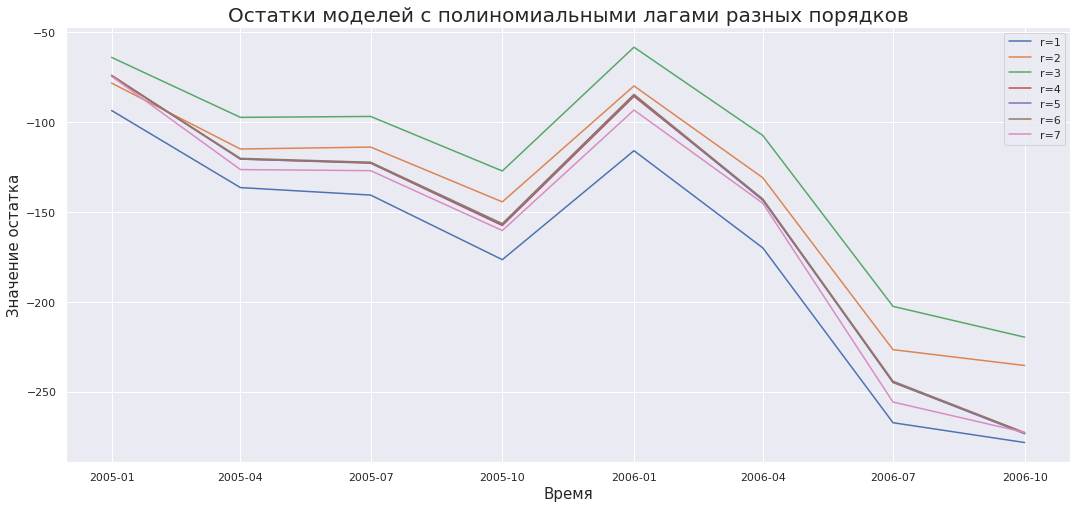

In [33]:
date = pd.date_range('2005-01-01', '2006-10-01', freq ='QS')
plt.figure(figsize=(18, 8))
plt.grid()

for i in range(7):
    diff = y_test - res_y[i]
    plt.plot(date, diff, label='r=%d' % (i + 1))

plt.xlabel('Время', size=15)
plt.ylabel('Значение остатка', size=15)
plt.title('Остатки моделей с полиномиальными лагами разных порядков', size=20)
plt.grid()
plt.legend()
plt.show()

Ну, уже невооруженным глазом видно, что остатки не являются стационарными. Как минимум, можно видеть убывающий тренд, который противоречит стационарности. Но ради интереса посмотрим на коррелограмму остатков. Паттерны у всех графиков похожи, так 

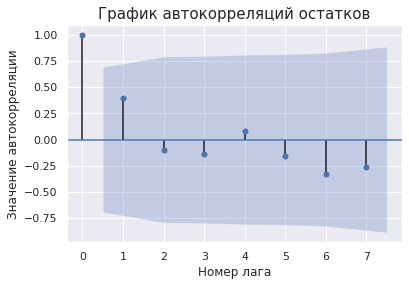

In [34]:
plot_acf(diff)
plt.title('График автокорреляций остатков', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение автокорреляции', size=12)
plt.show()

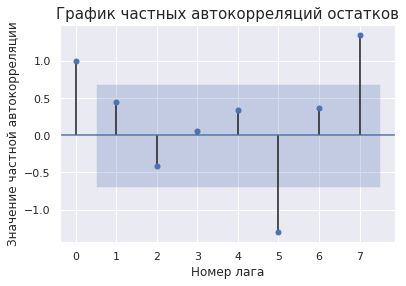

In [35]:
plot_pacf(diff)
plt.title('График частных автокорреляций остатков', size=15)
plt.xlabel('Номер лага', size=12)
plt.ylabel('Значение частной автокорреляции', size=12)
plt.show()

Как можно видеть, с автокорреляциями все в норме - все лаги, кроме нулевого незначимые, а вот с частными автокорреляциями уже все более грустно. Так что очевидно, что построенная модель не использует всю информацию исходного ряда. Так что остатки не являются стационарными и некоррелированными

# Комбинированный метод

## ADL-модель (2 балла)

Предлагается попытаться объединить два вышеописанных метода. На семинаре мы обсуждали, что прогнозировать прямым или рекурсивным методом ARIMAX-модель напрямую может быть проблемно, так как придётся либо выписывать специфические правдобия, либо подставлять для экзогенных переменных прогнозы. Поэтому для того, чтобы объединить учёт эндогенной и экзогенной информации, предлагается оценивать ADL-модели. Такие модели уже можно оценивать МНК, т.е. банально оценивать линейную регрессию как в предыдущем пункте. 

Для прогнозирования используйте прямую стратегию. Для каждой точки прогноза предназначена своя отдельная модель, как и ранее. На всякий случай выпишу уравнения, которые необходимо оценить:

$y_t = \beta_0 + \beta_1 y_{t-1} + ... +\beta_p y_{t-p} + \gamma_1 x_{t-1} + ... + \gamma_f x_{t-f} + \epsilon_t$

$y_{t+1} = \beta_0 + \beta_1 y_{t-1} + ... +\beta_p y_{t-p} + \gamma_1 x_{t-1} + ... + \gamma_f x_{t-f} + \epsilon_t$

...

$y_{t+7} = \beta_0 + \beta_1 y_{t-1} + ... +\beta_p y_{t-p} + \gamma_1 x_{t-1} + ... + \gamma_f x_{t-f} + \epsilon_t$

Параметры p и f подберите на основе вневыборочной ошибки прогноза на кросс-валидации. Определите для себя какие-нибудь небольшие p и f (не более 5).



In [36]:
# ༼ つ ◕_◕ ༽つ

In [37]:
print('плак :c ' * 20)

плак :c плак :c плак :c плак :c плак :c плак :c плак :c плак :c плак :c плак :c плак :c плак :c плак :c плак :c плак :c плак :c плак :c плак :c плак :c плак :c 


## Визуализация прогнозов (0.5 балла)

Красиво визуализируйте на последнем окне кросс-валидации прогнозы всех трёх моделей (эндогенной, экзогенной и комбинированной) и истинных значений ряда. Какая модель оказалась более точной?


Надеюсь, за этот номер хоть что-то поставят без предыдущего(

А то что за подстава :с

Ну, для начала посчитаем прогноз модели с распределенными лагами

In [38]:
y_d = []
df = X.loc[8:, :].copy()
target = y[8:].copy()

for i in range(0, 8):
    x_train = df.head(df.shape[0] - 9)
    y_train = target[:-9]

    cur_mod = LinearRegression(fit_intercept=False)
    cur_mod.fit(x_train, y_train)
    y_d.append(*cur_mod.predict(np.array(x_test).reshape(1, -1)))

    df = df.shift()
    df = df.tail(df.shape[0] - 1)
    target = target[1:]

Чтобы не нагромождать график, для примера предсказания модели с полиномиальными лагами выизуализируем прогноз модели с r = 1, тем более изначально мы хотели найти модель с как можно более маленьким r

In [43]:
df = X.loc[8:, :].copy()
target = y[8:].copy()
res_p = []
for i in range(0, 8):
    x_train = df.head(df.shape[0] - 9)
    y_train = target[:-9]

    cur_mod = LinearRegression(fit_intercept=False)
    cur_mod.fit(x_train, y_train)
    bet = cur_mod.coef_
    delt = bet[0]
    bet = bet[1:]

    betas_cur = find_betas(1, LinearRegression(fit_intercept=False), bet)
    params = list([delt]) + list(betas_cur)
    cur_y = x_test @ params
    res_p.append(cur_y)

    df = df.shift()
    df = df.tail(df.shape[0] - 1)
    target = target[1:]

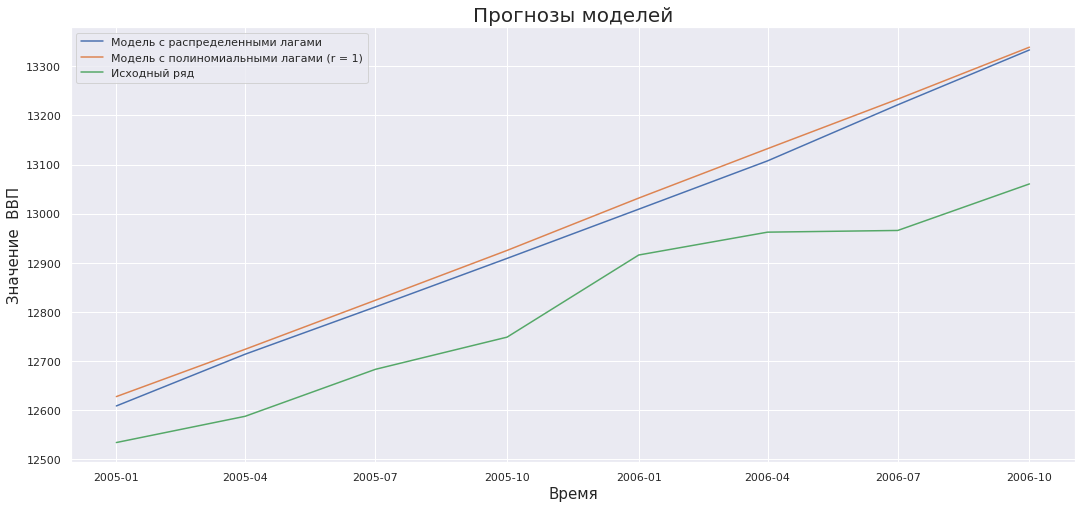

In [46]:
date = pd.date_range('2005-01-01', '2006-10-01', freq ='QS')
plt.figure(figsize=(18, 8))
plt.grid()

plt.plot(date, y_d, label='Модель с распределенными лагами')
plt.plot(date, res_p, label='Модель с полиномиальными лагами (r = 1)')
plt.plot(date, y[-8:], label='Исходный ряд')

plt.xlabel('Время', size=15)
plt.ylabel('Значение  ВВП', size=15)
plt.title('Прогнозы моделей', size=20)
plt.grid()
plt.legend()
plt.show()

Такие вот дела... Как можно видеть, прогнозы модели с распределенными и модели с полиномиальными лагами почти совпадают. Посчитаем качество прогноза.

In [48]:
print('MAPE модели с распределенными лагами: ', mean_absolute_percentage_error( y[-8:], y_d), "%", sep='')
print('MAPE модели с полиномиальными лагами (r = 1): ', mean_absolute_percentage_error( y[-8:], res_p), "%", sep='')

MAPE модели с распределенными лагами: 1.2202319912060196%
MAPE модели с полиномиальными лагами (r = 1): 1.3408432691345673%


Как можно заметить, качество модели сраспределенными лагами немножечко лучше. Но если бы мы взяли r побольше, то кратина бы поменялась, и модель с полиномиальными лагами была бы немножко лучше.

# Мемы (Респект семинариста и ассистента)

Скиньте мем. Желательно смешной.

Тут будут не мемы, а жизненные картинки...

<img src="https://sun9-16.userapi.com/impf/c855420/v855420995/15a84d/80cleYk74qQ.jpg?size=490x421&quality=96&proxy=1&sign=1e823ab7078ac80b4a87724dc5633624">

<img src="https://sun9-43.userapi.com/impg/7XIzjeT-zYSPl_viWFrfGE-sSS7ydYh6rwPwvA/x85viG7Vr_g.jpg?size=2000x1066&quality=96&proxy=1&sign=109674633f7a443a01a6adcb3f51bada">

<img src="https://sun9-28.userapi.com/impg/3U33JqMpHjaYGeKUYnuOTYaMByh9XgeQ0Vg0XQ/7Ih-sUzMZho.jpg?size=1080x933&quality=96&proxy=1&sign=52da7e2ec362214be2bd7220b0c93f0a">

<img src="https://sun9-25.userapi.com/impg/_3DrdwC3fzMAqjCrqKS869gWZ7nkaB0hpqaJTg/2BRiBUVDmZs.jpg?size=499x499&quality=96&proxy=1&sign=2d24e35ab340b49d0848c4c8b483d419">

<img src="https://sun9-11.userapi.com/impg/nRFr2xo31FTVEs7s3YZdx3pBTJHFoDTBcnovow/B7gmcLMeF7w.jpg?size=972x1080&quality=96&proxy=1&sign=c832579bb3d3c81a614d96f4b289bf9e">

<img src="https://sun9-14.userapi.com/impf/mpQeeMhHNMGsyD29EriV19NNLgl3GAoNDGH4eQ/akzyDIp2Z40.jpg?size=1000x1129&quality=96&proxy=1&sign=84429fafebf233ddd74f60ea15f0ef06">

